In [1]:
import harp
import utils
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce

harp_reader = harp.create_reader('device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData()
rules_reader = utils.SessionData()
video_reader = utils.Video()

harp_datafolder = r'../temp_data/2024-02-20T18-47-30/Expander/'
settings_datafolder = r'../temp_data/2024-02-20T18-47-30/SessionSettings/'
rules_datafolder = r'../temp_data/2024-02-20T18-47-30/RuleSettings/'
video_datafolder = r'../temp_data/2024-02-20T18-47-30/VideoData/'

In [2]:
# read experiment metadata
session_settings = utils.load_json(session_data_reader, settings_datafolder)

rule_settings = utils.load_json(rules_reader, rules_datafolder)

print(session_settings)
print(rule_settings)

                                                                     metadata
2024-02-20 18:47:30.398591  {'lineMappings': {'odorMap': [DotMap(name='Odo...
                                                                     metadata
2024-02-20 18:47:30.398591  {'ruleAlias': 'Rule1', 'stateDefinitions': [{'...


In [3]:
# read experiment video
video_data = utils.load_video(video_reader, video_datafolder)

print(video_data)

                            hw_counter   hw_timestamp  _frame  \
Time                                                            
2024-02-20 18:47:35.262495       24248  1613030131752       0   
2024-02-20 18:47:35.272480       24249  1613050131728       1   
2024-02-20 18:47:35.282495       24250  1613070131712       2   
2024-02-20 18:47:35.292479       24251  1613090132016       3   
2024-02-20 18:47:35.302495       24252  1613110132176       4   
...                                ...            ...     ...   
2024-02-20 18:49:13.532479       34075  1809568726600    1272   
2024-02-20 18:49:13.542496       34076  1809588726752    1273   
2024-02-20 18:49:13.552480       34077  1809608725976    1274   
2024-02-20 18:49:13.562496       34078  1809628726144    1275   
2024-02-20 18:49:13.572480       34079  1809648726048    1276   

                                                                        _path  \
Time                                                                     

DotMap(lineMappings=DotMap(odorMap=[DotMap(name='OdorA', line=6), DotMap(name='OdorB', line=7), DotMap(name='OdorC', line=8), DotMap(name='OdorD', line=9)], portLine=0, vacuumLine=2, auxLine=0), metadata=DotMap(animalId='plimbo', loggingRootPath='C:\\Users\\Delphi1983\\Delphi\\temp_data\\', remoteTransferRootPath='', chargeTime=0.2, minimumPokeTime=0.01, maximumPokeTime=10.0, robocopyTimeInterval=3600.0, showHarpLeds=False, maxVideoLength=20.0, minOdorDelivery=0.1, maxOdorDelivery=8.0, switchTime1=0.01, switchTime2=0.02, vacuumDelay=0.005, vacuumDuration=0.05, useVacuum=False), cameraProperties=DotMap(imagingRate=100.0, preEventTime=2.5, postEventTime=2.5))
                                Aux0   Out0 Out2   Out6   Out7   Out8   Out9
Time                                                                        
2024-02-20 18:47:37.310495853    NaN  False  NaN    NaN    NaN    NaN    NaN
2024-02-20 18:47:37.344480038    NaN    NaN  NaN  False    NaN    NaN    NaN
2024-02-20 18:47:37.345503

C:\Users\erski\AppData\Local\Temp\ipykernel_18712\1598852427.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.plot(merged["Out0"].ffill().loc[start_time : end_time] + 1.1, drawstyle='steps-post')
C:\Users\erski\AppData\Local\Temp\ipykernel_18712\1598852427.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled = merged.ffill()


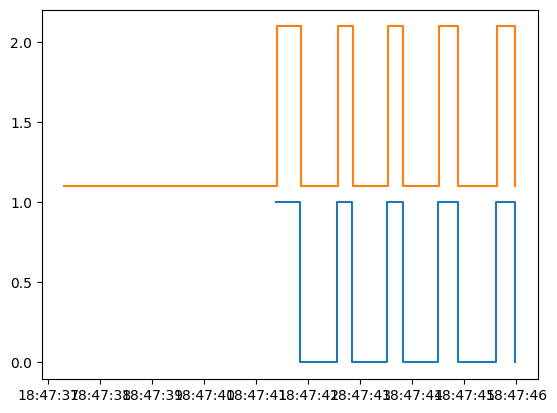

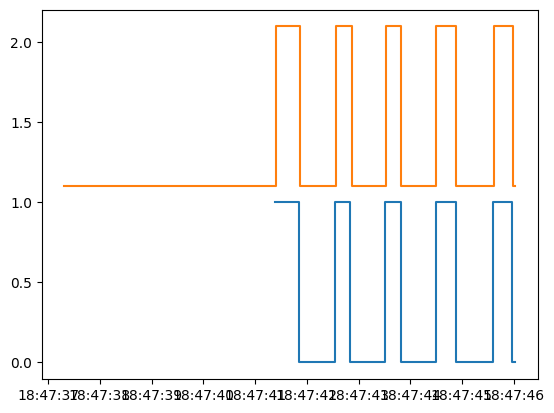

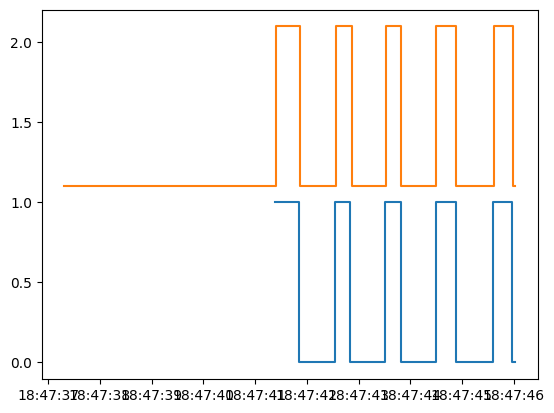

In [10]:
# Read HARP device streams, conditioned on mappings found in the session metadata
metadata = session_settings.iloc[0]['metadata']
print(metadata)

# Extract line mappings from metadata
aux_line = f'Aux{metadata.lineMappings.auxLine}'
port_line = f'Out{metadata.lineMappings.portLine}'
vacuum_line = f'Out{metadata.lineMappings.vacuumLine}'
odorA = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorA'), None)}"
odorB = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorB'), None)}"
odorC = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorC'), None)}"
odorD = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorD'), None)}"

# Aux line containing poke events
poke_events = utils.load(harp_reader.AuxInState, harp_datafolder)[aux_line]

# times when outputs were set to HIGH (e.g. port valve opening, manifold valve opening)
outputs_HIGH = utils.load(harp_reader.OutputSet, harp_datafolder)
# times when outputs were set to LOW (e.g. port valve closing, manifold closing)
outputs_LOW = utils.load(harp_reader.OutputClear, harp_datafolder)

# convert LOW and HIGH events to port state dataframes
line_states = {
    "poke_events": poke_events,
    "port_line_state": utils.concat_digi_events(outputs_LOW[port_line], outputs_HIGH[port_line]),
    "vacuum_line_state": utils.concat_digi_events(outputs_LOW[vacuum_line], outputs_HIGH[vacuum_line]),
    "odorA_state": utils.concat_digi_events(outputs_LOW[odorA], outputs_HIGH[odorA]),
    "odorB_state": utils.concat_digi_events(outputs_LOW[odorB], outputs_HIGH[odorB]),
    "odorC_state": utils.concat_digi_events(outputs_LOW[odorC], outputs_HIGH[odorC]),
    "odorD_state": utils.concat_digi_events(outputs_LOW[odorD], outputs_HIGH[odorD])
}

# debug plotting
start_time = session_settings.index[0][0] - pd.Timedelta(seconds=1)
end_time = start_time + pd.Timedelta(seconds=20)

plt.figure() 
plt.plot(line_states["poke_events"].loc[start_time : end_time], drawstyle='steps-post')
plt.plot(line_states["port_line_state"].loc[start_time : end_time] + 1.1, drawstyle='steps-post')

# consolidate digital lines into as single DataFrame
merged = pd.merge(line_states["poke_events"], line_states["port_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["vacuum_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorA_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorB_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorC_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorD_state"], left_on="Time", right_on="Time", how="outer")

plt.figure()
plt.plot(merged["Aux0"].ffill().loc[start_time : end_time], drawstyle='steps-post')
plt.plot(merged["Out0"].ffill().loc[start_time : end_time] + 1.1, drawstyle='steps-post')

# check that forward fill is consistent
filled = merged.ffill()
plt.figure()
plt.plot(filled["Aux0"].loc[start_time : end_time], drawstyle='steps-post')
plt.plot(filled["Out0"].loc[start_time : end_time] + 1.1, drawstyle='steps-post')

print(merged.loc[start_time : end_time])

In [7]:
# Some of our data is still in an array form (e.g. port closing, opening) - we now want to give readable names
print(pokes)

                                Aux0   Aux1  Aux0Changed  Aux1Changed
Time                                                                 
2024-02-20 18:47:41.381055832   True  False         True        False
2024-02-20 18:47:41.845888138  False  False         True        False
2024-02-20 18:47:42.548160076   True  False         True        False
2024-02-20 18:47:42.844064236  False  False         True        False
2024-02-20 18:47:43.516223907   True  False         True        False
2024-02-20 18:47:43.824863911  False  False         True        False
2024-02-20 18:47:44.491072178   True  False         True        False
2024-02-20 18:47:44.881375790  False  False         True        False
2024-02-20 18:47:45.606143951   True  False         True        False
2024-02-20 18:47:45.975264072  False  False         True        False
2024-02-20 18:48:41.907743931   True  False         True        False
2024-02-20 18:48:42.121823788  False  False         True        False
2024-02-20 18:48:42.

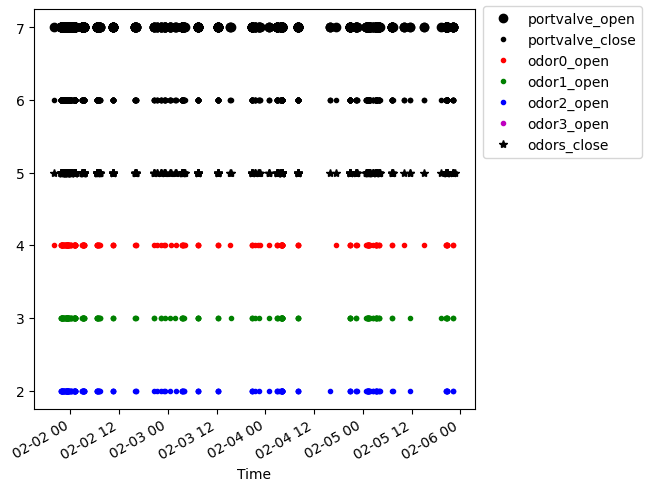

In [43]:
portvalve_open = pokes.Aux0[pokes.Aux0] * 0 + 7
portvalve_close = pokes.Aux0[~pokes.Aux0] * 0 + 6
odors_close = outputs_LOW.Out6[outputs_LOW.Out6] * 0 + 5

odor0_open = outputs_HIGH.Out6[outputs_HIGH.Out6] * 0 + 4
odor1_open = outputs_HIGH.Out7[outputs_HIGH.Out7] * 0 + 3
odor2_open = outputs_HIGH.Out8[outputs_HIGH.Out8] * 0 + 2
odor3_open = outputs_HIGH.Out9[outputs_HIGH.Out9] * 0 + 1

start_time = pd.to_datetime('2023-12-12T17:41:06')
end_time = start_time + pd.Timedelta('10sec')

fig, ax = plt.subplots(layout='constrained')
portvalve_open.plot(ax=ax, style='ko', label='portvalve_open')
portvalve_close.plot(ax=ax, style='k.', label='portvalve_close')
odor0_open.plot(ax=ax, style='r.', label='odor0_open')
odor1_open.plot(ax=ax, style='g.', label='odor1_open')
odor2_open.plot(ax=ax, style='b.', label='odor2_open')
odor3_open.plot(ax=ax, style='m.', label='odor3_open')
odors_close.plot(ax=ax, style='k*', label='odors_close')
fig.legend(loc='outside right upper')
# pokes.Aux0.astype('uint8').plot(style='.')
# portvalve_open[start_time:end_time]